Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

# Основные итоги 

### Научный вывод:
Проведенный A/B тест продемонстрировал следующее:

1. **Среднее время доставки** в тестовой группе уменьшилось на 13.35% по сравнению с контрольной группой.
2. **Результаты статистических тестов**:
   - T-тест: $p = 0.0$, что указывает на статистически значимую разницу между группами.
   - U-тест Манна–Уитни: $p = 0.0$, что также подтверждает значимость разницы.
3. **Стандартное отклонение**:
   - Контрольная группа: $\sigma = 9.99 $
   - Тестовая группа: $\sigma = 9.88 $


   Это свидетельствует о схожей вариативности данных в обеих группах.

### Вывод:
Уменьшение времени доставки в тестовой группе на 13% является статистически значимым. Это подтверждает, что внедрение нового алгоритма положительно влияет на эффективность доставки.

-----------------------

### Понятный вывод:
Тест показал, что новая функция помогает сократить время доставки, поэтому ее стоит внедрить. В среднем курьеры в тестовой группе справлялись с заказами на 13% быстрее, чем в контрольной.

# Покажем, как получены данные выводы

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
from scipy.stats import ttest_ind, normaltest
import pandas as pd


In [2]:
data = pd.read_csv('experiment_lesson_4.csv')
df = data.copy()
df

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


## EDA

In [3]:
df.shape

(20196, 4)

In [4]:
df = df.drop_duplicates()
df.shape

(20196, 4)

In [5]:
df.isnull().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [6]:
df["delivery_time"].describe()

count    20196.000000
mean        42.054169
std         10.382196
min         10.000000
25%         35.000000
50%         42.000000
75%         49.000000
max         83.000000
Name: delivery_time, dtype: float64

In [7]:
df.describe(include=['object'])

,district,experiment_group
count,20196,20196
unique,3,2
top,Purlieus,test
freq,16960,10104


In [8]:
df["experiment_group"].value_counts()

experiment_group
test       10104
control    10092
Name: count, dtype: int64

In [9]:
10104-10092

12

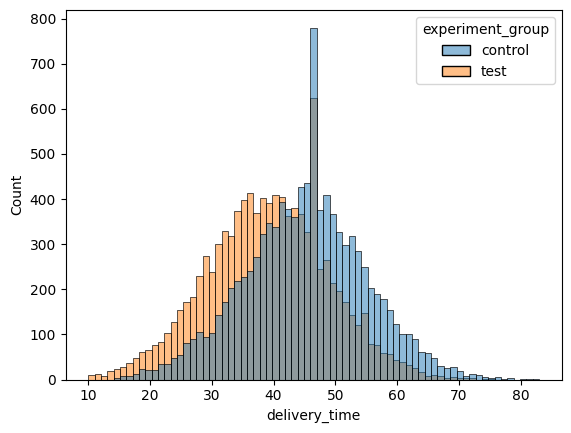

In [10]:
sns.histplot(data=df, x='delivery_time', hue='experiment_group');

## A/B

In [11]:
control_data = df[df["experiment_group"] == "control"]["delivery_time"]
test_data = df[df["experiment_group"] == "test"]["delivery_time"]

$H_0$: Данные имеют нормальное распределение.


$H_A:$ Данные не имеют нормального распределения.

In [12]:
normaltest(control_data, nan_policy='omit')

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [13]:
normaltest(test_data, nan_policy='omit')

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [14]:
control_data.std()

9.990016960246372

In [15]:
test_data.std()

9.883308351129061

Контрольная группа: 


$p> \alpha$ — распределение времени доставки не отличается от нормального на уровне значимости $\alpha =0.05$.


Тестовая группа: 


$p < \alpha$ — распределение времени доставки отклоняется от нормального на уровне значимости $\alpha =0.05$.

В этом случае лучше применить непараметрический U-тест Манна–Уитни, который не требует нормальности распределений. Однако если посмотреть на саму форму распределения, то оно не настолько сильно нарушает нормальность, поэтому применим Т-тест.


$H_0: \mu_{control} =\mu_{test}$ Среднее время доставки в тестовой и контрольной группах одинаково.


$H_A: \mu_{control} \neq \mu_{test}$
Среднее время доставки в тестовой и контрольной группах отличается.

In [16]:
ttest_ind(control_data, test_data, equal_var=False, alternative="greater")

TtestResult(statistic=43.035552024241454, pvalue=0.0, df=20191.127787584755)

Сравним с критерием Манна–Уитни

In [17]:
stats.mannwhitneyu(control_data, test_data, alternative="greater")

MannwhitneyuResult(statistic=67984508.0, pvalue=0.0)

Посмотрим на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной

In [18]:
control_mean = control_data.mean()
test_mean = test_data.mean()

percentage_change = round(((test_mean - control_mean) / control_mean) * 100, 2)
percentage_change

-13.35